# 0. Set up file 

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
from plott import plott
import scipy.interpolate
from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
import time
from IPython import embed
import os
from matplotlib import gridspec
import re

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

%matplotlib inline

/home/z5145948/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/z5145948/miniconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/z5145948/miniconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/z5145948/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/z5145948/miniconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/z5145948/miniconda2/lib/python2.7/site-packages/ipykernel/

In [2]:
# Define the d13C contour characterisics
cmap = 'gist_rainbow'
d13C_color_min = -0.5
d13C_color_max = 1.25
# d13C_color_levels = np.arange(d13C_color_min, d13C_color_max, (d13C_color_max-(d13C_color_min))/50)

# Import standardised latitudes and depths
lat_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')

# File saving location
overleaf_loc = '/home/z5145948/Dropbox/Apps/Overleaf/Paper_2/Figures'

dividing_depth = 2500

# The length of time of each slice
slice_width = 1

# Holocene and LIG peak regions for T-test

Hol_max_limits = (2,8)
LIG_max_limits = (118,127)

In [3]:
# Define function for standardising axes

def d13C_axes_correction(fig, ax, output, label = '', yax_label = '', xax_label = '', legend = False):
    
    # Add legend
    if legend == True:
        divider = make_axes_locatable(ax)
        colorbar_ax = divider.append_axes("right",size="5%",pad=0.05)
        colorbar_ax = fig.colorbar(output, cax = colorbar_ax)
        colorbar_ax.set_label(u'$\delta^{13}$C (\u2030)', fontsize = axis_label_font)
        colorbar_ax.ax.tick_params(labelsize=axis_label_font)

    # Add optional labels to subplot
    ax.text(60, 4500, label, fontsize = medium_font)
    ax.set_ylabel(yax_label)
    ax.set_xlabel(xax_label)
    
    # Flip plot
    ax.invert_yaxis()
    
    # Define out of bounds colour
    output.cmap.set_under('k')
    output.cmap.set_over('k')

    # Define plot limits
    depth_min = 0
    depth_max = 5000
    lat_min = -90
    lat_max = 90

    # Apply limits
    ax.set_ylim(depth_max, depth_min)
    ax.set_xlim(lat_min, lat_max)
    
    # Correct font sizes in axes
    for item in ([ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(small_font) 
    
    return(ax, output)
    

In [4]:
####3 reading data function

def read_data(folder):

    # Import simulation details (summary) as dataframe
    summary = pd.read_csv(folder + '_summary.txt', delimiter = ' ')

    # Import simulation outputs
    fh = Dataset(folder + 'output.nc')
    proxy_simulations = fh.variables['var1_1'][:] 

    # Import samples (proxy data)
    samples = pd.read_csv( folder + '_samples.txt', delimiter = ' ')

    # Drop all unnecessary rows in summary
    summary = summary.drop(['type', 'Row.names', 'reps', 'model', 'dataset', 'filename', 'success.rate'], axis = 1)

    # Convert run.no to netcdf file index
    summary['run.no'] = summary['run.no'] - 1
    samples['run.no'] = samples['run.no'] - 1
    
    return(proxy_simulations, samples, summary)

In [5]:
#### import some UVic data

# Set up graph

dep = dep_standardised
lat = lat_standardised                                                                                                                                                                                                                     

zo_min = 0.6
zo_max = 1.3

fig1 = plt.figure(1)
ax1 = plt.subplot2grid((2,1), (0,0))

# get the model output for the mask

ax1, var_U, lat_U, lon_U, tim_U, dep_U, data_form_U, mask_U = plott('UVic','/srv/ccrc/data06/z5145948/UVic/PI/','O_dic13',9000,10000,'cross',fig1,ax1,0,5000,'y',zo_min, zo_max, mask='NA')

# Adjust the mask

mask_U_original = mask_U.copy()

mask_U = np.mean(mask_U, axis = 0)

X, Y = np.meshgrid(dep_U, lat_U)
XI, YI  = np.meshgrid(dep_standardised, lat_standardised)

new_mask = np.empty((len(lon_U), len(lat_standardised), len(dep_standardised)))

for i in  np.arange(0, mask_U[0,0,:].shape[0]):
    mask_regridded_U = scipy.interpolate.griddata((X.flatten(), Y.flatten()), (mask_U[:,:,i].T).flatten() , (XI, YI),method='linear')
    new_mask[i,:,:] = mask_regridded_U

new_mask = new_mask.T
mask_U = new_mask
mask_U = np.ma.masked_where(mask_U == 0, mask_U)

mask = mask_U

# Set the lon

lon = lon_U

plt.close()


tavg.09120.01.01.nc
tavg.09220.01.01.nc
tavg.09320.01.01.nc
tavg.09420.01.01.nc
tavg.09520.01.01.nc
tavg.09620.01.01.nc
tavg.09720.01.01.nc
tavg.09820.01.01.nc
tavg.09920.01.01.nc
((100, 19, 100, 100), 'var.shape', 3)


/home/z5145948/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:1540: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/z5145948/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:1541: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [6]:
# Define standard fontsize
small_font = 10
axis_label_font = 10
medium_font = 12
title_font = 16

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

In [7]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt'] ## this last one is Cib. spp. (so, not just cib. wuellerstorfi)


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']
    
    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > float(minn)]
    df = df[df['age'].astype(float) < float(maxx)]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > float(minn)]
    df2 = df2[df2['age'].astype(float) < float(maxx)]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [8]:

def pl_cores(minn, maxx):

    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data
    indopac = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df = pd.concat([indopac, add])
    df = df.reset_index(drop=True)

    df['d18O names'] = df['Core'] + '_ageLS16.txt'
    df['d13C names'] = df['Core'] + '_d13C.txt'

    # Loop over the dataset and interpolate each core
    i = 0
    results_dict = {}

    while i < df.count()[0]:

        try:
            df_d18O = pd.read_table('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        
        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue

        df_d13C = df_d13C.dropna(subset = ['age'])
        df_d13C = df_d13C.reset_index(drop = True)

        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        if len(df_d13C) > 0:
            df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
            df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

            df_d13C = df_d13C.drop(['depth'], axis = 1)

            df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            results_dict.update({
                df_results.Core[0] : df_results.drop(['Core'], axis = 1)
            })

        i += 1
    
    df_results = pd.concat(results_dict).reset_index()
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

In [9]:
# ################## read in the oliver data using the predefined function

### Redo the age model for the peterson dataset

years = pd.read_csv('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/year_range.txt', delimiter = ' ')

# Age range to look over
Hol_min = 1
Hol_max = 20

df_pl = pl_cores(Hol_min,Hol_max)

df_oliver = Oliver_cores(Hol_min,Hol_max)

###################3 join the dataframes

df_results = df_pl.append(df_oliver)
  
#################### get only the pacific cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df_pac = df[df['Location'] == 'Pacific']
df_pac = df_pac.reset_index(drop = True)
df_pac['age'] = df_pac.age.astype(float)

# Slice the data
lower = np.arange(Hol_min, Hol_max, 1)
upper = np.arange(Hol_min+1, Hol_max+1, 1)

proxy_compilation = {}

for low, up in zip(lower, upper):
    df_slice = df_pac[(df_pac['age'] >= low) & (df_pac['age'] < up)]
    grouped_slice = df_slice.groupby(['Lat', 'Lon', 'Dep'])

    slice_averaged = {}
    
    i = 0
    for key, group in grouped_slice:
        group_averaged = group.mean()
        group_count = group.count()
        group_averaged['count'] = group_count['d13C']
        slice_averaged.update({
            i : pd.DataFrame(group_averaged)
        })
        i += 1

    slice_averaged = pd.concat(slice_averaged, axis=1).T.reset_index(drop=True)
    slice_averaged = slice_averaged.drop(['age'],axis=1)
    
    proxy_compilation.update({
        low : slice_averaged.T
    })

proxy_compilation = pd.concat(proxy_compilation,axis=1).T.reset_index(drop=False)
proxy_compilation = proxy_compilation.drop(columns=['level_1'],axis=1)
proxy_compilation = proxy_compilation.rename(columns={'level_0' : 'lower', 'Dep' : 'Ocean_depth'})
Hol_samples = proxy_compilation
Hol_deeper_samples = Hol_samples[Hol_samples['Ocean_depth'] > dividing_depth]


In [10]:
# ################## read in the oliver data using the predefined function

### Redo the age model for the peterson dataset

years = pd.read_csv('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/year_range.txt', delimiter = ' ')

# Age range to look over
LIG_min = 110
LIG_max = 140

df_pl = pl_cores(LIG_min,LIG_max)

###################3 join the dataframes #######NOT DONE FOR THE PACIFIC

df_results = df_pl
  
#################### get only the pacific cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df_pac = df[df['Location'] == 'Pacific']
df_pac = df_pac.reset_index(drop = True)
df_pac['age'] = df_pac.age.astype(float)

# Slice the data
lower = np.arange(LIG_min, LIG_max, 1)
upper = np.arange(LIG_min+1, LIG_max+1, 1)

proxy_compilation = {}

for low, up in zip(lower, upper):
    df_slice = df_pac[(df_pac['age'] >= low) & (df_pac['age'] < up)]
    grouped_slice = df_slice.groupby(['Lat', 'Lon', 'Dep'])

    slice_averaged = {}

    i = 0
    for key, group in grouped_slice:
        group_averaged = group.mean()
        group_count = group.count()
        group_averaged['count'] = group_count['d13C']
        slice_averaged.update({
            i : pd.DataFrame(group_averaged)
        })
        i += 1

    slice_averaged = pd.concat(slice_averaged, axis=1).T.reset_index(drop=True)
    slice_averaged = slice_averaged.drop(['age'],axis=1)
    
    proxy_compilation.update({
        low : slice_averaged.T
    })

proxy_compilation = pd.concat(proxy_compilation,axis=1).T.reset_index(drop=False)
proxy_compilation = proxy_compilation.drop(columns=['level_1'],axis=1)
proxy_compilation = proxy_compilation.rename(columns={'level_0' : 'lower', 'Dep' : 'Ocean_depth'})
LIG_samples = proxy_compilation
LIG_deeper_samples = LIG_samples[LIG_samples['Ocean_depth'] > dividing_depth]


In [11]:
# Set up the graphs

total_graph_width = 17
width_hol = float((Hol_max - Hol_min))
width_lig = float((LIG_max - LIG_min))


/home/z5145948/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


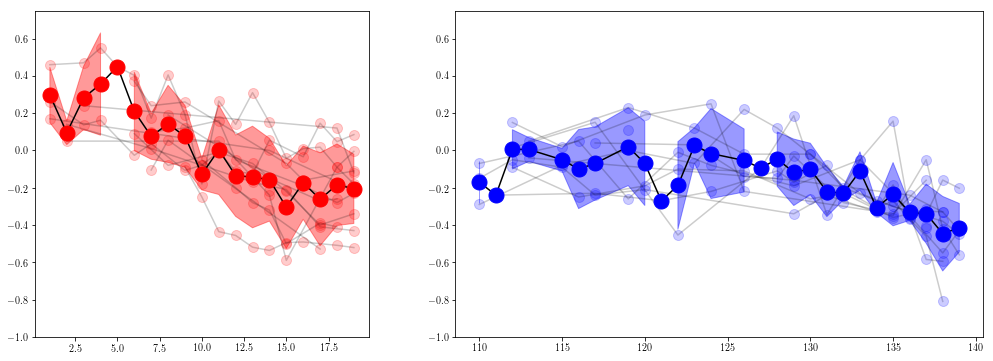

(2740.0, 3968.0)


In [12]:
# plot it
fig = plt.figure(figsize=(total_graph_width, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[width_hol, width_lig]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

df_hol = Hol_deeper_samples
df_lig = LIG_deeper_samples

############ Hol ##################
# Plot all of the points inside a region on a time-d13C plot

unique_lats = np.unique(df_hol['Lat'])
years_list = np.unique(df_hol.lower)

interpolated_proxies = {}

for unique_lat in unique_lats:
    
    # get a single proxy
    df_temp = df_hol[df_hol['Lat'] == unique_lat]
    
    ax1.plot(df_temp.lower, df_temp.d13C, 'k', df_temp.lower, df_temp.d13C, 'ro', alpha=0.2, ms=10)
    
# Plot the average of all the cores onto the same plot with stdev shaded region around it

averaged_points = df_hol.groupby('lower').mean()
stdev_points = df_hol.groupby('lower').std()

ax1.fill_between(averaged_points.index,
                 averaged_points.d13C-stdev_points.d13C,
                 averaged_points.d13C+stdev_points.d13C,
                 zorder=-100,
                 color='r',
                 alpha=0.4)


ax1.plot(averaged_points.index, averaged_points.d13C, 'k',
         averaged_points.index, averaged_points.d13C, 'ro',
         zorder=100,
         ms=15)

############ LIG ##################
# Plot all of the points inside a region on a time-d13C plot

unique_lats = np.unique(df_lig['Lat'])
years_list = np.unique(df_lig.lower)

interpolated_proxies = {}

for unique_lat in unique_lats:
    
    # get a single proxy
    df_temp = df_lig[df_lig['Lat'] == unique_lat]
    
    ax2.plot(df_temp.lower, df_temp.d13C, 'k', df_temp.lower, df_temp.d13C, 'bo', alpha=0.2, ms=10)
    
# Plot the average of all the cores onto the same plot with stdev shaded region around it

averaged_points = df_lig.groupby('lower').mean()
stdev_points = df_lig.groupby('lower').std()

ax2.fill_between(averaged_points.index,
                 averaged_points.d13C-stdev_points.d13C,
                 averaged_points.d13C+stdev_points.d13C,
                 zorder=-100,
                 color='b',
                 alpha=0.4)


ax2.plot(averaged_points.index, averaged_points.d13C, 'k',
         averaged_points.index, averaged_points.d13C, 'bo',
         zorder=100,
         ms=15)

#######################

## Make axes the same
d13C_list = pd.concat([df_hol, df_lig]).d13C
d13C_min = np.min(d13C_list)
d13C_max = np.max(d13C_list)

# Round these numbers up to the nearest 0.25
d13C_min = -(math.trunc(-d13C_min) + math.ceil((-d13C_min)%1 * 4) /4)
d13C_max = math.trunc(d13C_max) + math.ceil(d13C_max%1 * 4) /4

ax1.set_ylim(d13C_min, d13C_max)
ax2.set_ylim(d13C_min, d13C_max)

plt.show()

print(np.min(pd.concat([df_hol, df_lig]).Ocean_depth), np.max(pd.concat([df_hol, df_lig]).Ocean_depth))

/home/z5145948/miniconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/z5145948/miniconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


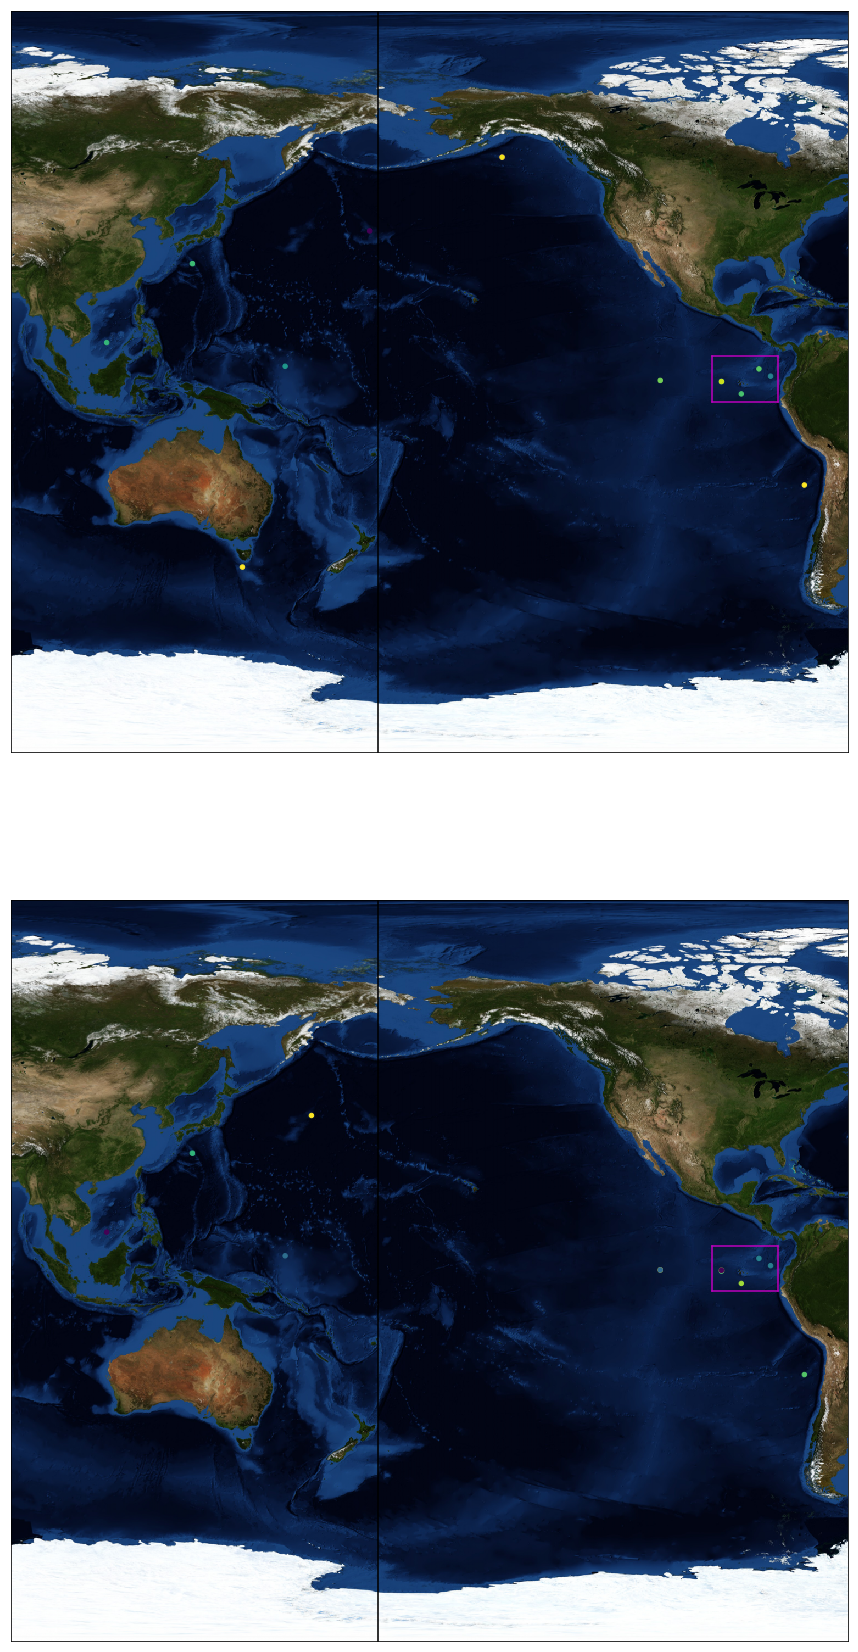

In [13]:
# Plot spatially all the cores

point_size = 20

fig = plt.figure(figsize=(50,30))
ax1 = subplot2grid((2,2),(0,0))
ax2 = subplot2grid((2,2),(0,1))

ax3 = subplot2grid((2,2),(1,0))
ax4 = subplot2grid((2,2),(1,1))

m = Basemap(ax = ax1, resolution = None, llcrnrlon = 90, urcrnrlon = 179, llcrnrlat = -90, urcrnrlat = 90)
m.bluemarble(scale=0.5)
m = Basemap(ax = ax2, resolution = None, llcrnrlon = -179, urcrnrlon = -65, llcrnrlat = -90, urcrnrlat = 90)
m.bluemarble(scale=0.5)

m = Basemap(ax = ax3, resolution = None, llcrnrlon = 90, urcrnrlon = 179, llcrnrlat = -90, urcrnrlat = 90)
m.bluemarble(scale=0.5)
m = Basemap(ax = ax4, resolution = None, llcrnrlon = -179, urcrnrlon = -65, llcrnrlat = -90, urcrnrlat = 90)
m.bluemarble(scale=0.5)

########### Holocene ###############

Hol_cores_averaged = Hol_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
Hol_cores_stdev = Hol_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

df_temp = Hol_cores_averaged[Hol_cores_averaged['Lon'] < 100]

ax2.scatter(df_temp.Lon, df_temp.Lat, c=df_temp.d13C,
           s=df_temp.groupby(['Lat','Lon','Ocean_depth']).count().reset_index().d13C*point_size)

df_temp = Hol_cores_averaged[Hol_cores_averaged['Lon'] > 0]

ax1.scatter(df_temp.Lon, df_temp.Lat, c=df_temp.d13C,
           s=df_temp.groupby(['Lat','Lon','Ocean_depth']).count().reset_index().d13C*point_size)

########### LIG ###############

LIG_cores_averaged = LIG_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
LIG_cores_stdev = LIG_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

df_temp = LIG_cores_averaged[LIG_cores_averaged['Lon'] < 100]

ax4.scatter(df_temp.Lon, df_temp.Lat, c=df_temp.d13C,
           s=df_temp.groupby(['Lat','Lon','Ocean_depth']).count().reset_index().d13C*point_size)

df_temp = LIG_cores_averaged[LIG_cores_averaged['Lon'] > 0]

ax3.scatter(df_temp.Lon, df_temp.Lat, c=df_temp.d13C,
           s=df_temp.groupby(['Lat','Lon','Ocean_depth']).count().reset_index().d13C*point_size)

# ################# Define regions

# Function for plotting box regions

def box_plot(ax1, ax2, lon_min, lon_max, lat_min, lat_max, col):
    for ax in [ax1, ax2]:
        ax.plot([lon_min, lon_max], [lat_min, lat_min],c=col)
        ax.plot([lon_min, lon_max], [lat_max, lat_max],c=col)
        ax.plot([lon_min, lon_min], [lat_min, lat_max],c=col)
        ax.plot([lon_max, lon_max], [lat_min, lat_max],c=col)

# Galapagos region

GA_lat_min = -5
GA_lat_max = 6
GA_lon_min = -98
GA_lon_max = -82

box_plot(ax2, ax4, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max,'m')

plt.subplots_adjust(wspace=-0.8233)
plt.show()

In [14]:
# get dataframes of data that are in the selected regions to compare across the Holocene and the LIG

def area_filter(df, lon_min, lon_max, lat_min, lat_max):
    
    df = df[(df.Lon > lon_min) & (df.Lon < lon_max) & (df.Lat < lat_max) & (df.Lat > lat_min)]
    
    return(df)

GA_Hol_cores = area_filter(Hol_deeper_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)
GA_LIG_cores = area_filter(LIG_deeper_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)


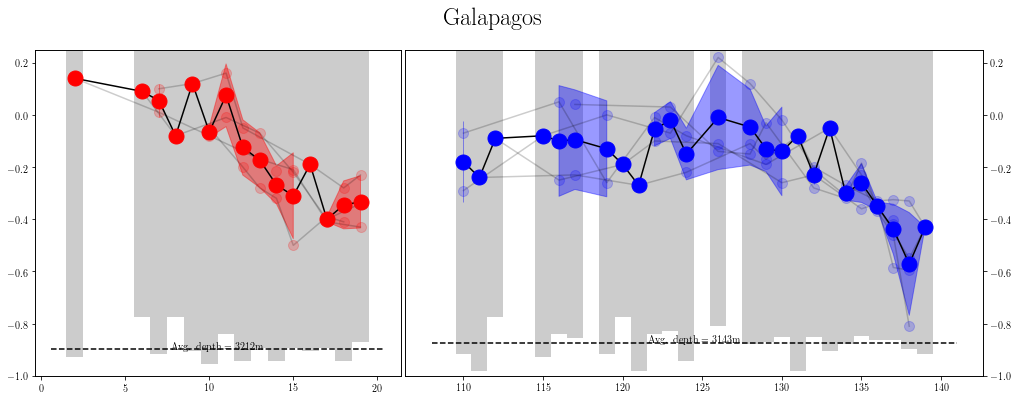

(2740.0, 3450.0)


In [15]:
# plot it
fig = plt.figure(figsize=(total_graph_width, 6))
plt.subplots_adjust(wspace=0.01)
gs = gridspec.GridSpec(1, 2, width_ratios=[width_hol, width_lig]) 
axHD = plt.subplot(gs[0])
axLD = plt.subplot(gs[1])

# Create new axes for plotting depth bins

axHC = axHD.twinx()
axLC = axLD.twinx()

df_hol = GA_Hol_cores
df_lig = GA_LIG_cores

############ Hol ##################
# Plot all of the points inside a region on a time-d13C plot

unique_lats = np.unique(df_hol['Lat'])
years_list = np.unique(df_hol.lower)

interpolated_proxies = {}

for unique_lat in unique_lats:
    
    # get a single proxy
    df_temp = df_hol[df_hol['Lat'] == unique_lat]
    
    axHC.plot(df_temp.lower, df_temp.d13C, 'k', df_temp.lower, df_temp.d13C, 'ro', alpha=0.2, ms=10)
    
# Plot the average of all the cores onto the same plot with stdev shaded region around it

averaged_points_hol = df_hol.groupby('lower').mean()
stdev_points_hol = df_hol.groupby('lower').std()

axHC.fill_between(averaged_points_hol.index,
                 averaged_points_hol.d13C-stdev_points_hol.d13C,
                 averaged_points_hol.d13C+stdev_points_hol.d13C,
                 zorder=-100,
                 color='r',
                 alpha=0.4)


axHC.plot(averaged_points_hol.index, averaged_points_hol.d13C, 'k',
         averaged_points_hol.index, averaged_points_hol.d13C, 'ro',
         zorder=100,
         ms=15)

############ LIG ##################
# Plot all of the points inside a region on a time-d13C plot

unique_lats = np.unique(df_lig['Lat'])
years_list = np.unique(df_lig.lower)

interpolated_proxies = {}

for unique_lat in unique_lats:
    
    # get a single proxy
    df_temp = df_lig[df_lig['Lat'] == unique_lat]
    
    axLC.plot(df_temp.lower, df_temp.d13C, 'k', df_temp.lower, df_temp.d13C, 'bo', alpha=0.2, ms=10)
    
# Plot the average of all the cores onto the same plot with stdev shaded region around it

averaged_points_lig = df_lig.groupby('lower').mean()
stdev_points_lig = df_lig.groupby('lower').std()

axLC.fill_between(averaged_points_lig.index,
                 averaged_points_lig.d13C-stdev_points_lig.d13C,
                 averaged_points_lig.d13C+stdev_points_lig.d13C,
                 zorder=-100,
                 color='b',
                 alpha=0.4)


axLC.plot(averaged_points_lig.index, averaged_points_lig.d13C, 'k',
         averaged_points_lig.index, averaged_points_lig.d13C, 'bo',
         zorder=100,
         ms=15)

#######################

## Make axes the same
d13C_list = pd.concat([df_hol, df_lig]).d13C
d13C_min = np.min(d13C_list)
d13C_max = np.max(d13C_list)

# Round these numbers up to the nearest 0.25
d13C_min = -(math.trunc(-d13C_min) + math.ceil((-d13C_min)%1 * 4) /4)
d13C_max = math.trunc(d13C_max) + math.ceil(d13C_max%1 * 4) /4

axHC.set_ylim(d13C_min, d13C_max)
axLC.set_ylim(d13C_min, d13C_max)

# Plot the depth bars

axHD.bar(averaged_points_hol.index, averaged_points_hol.Ocean_depth,width=slice_width,zorder=-10000,color='0.8')
axLD.bar(averaged_points_lig.index, averaged_points_lig.Ocean_depth,width=slice_width,zorder=-10000,color='0.8')

# Format the axes

axLD.get_yaxis().set_visible(False)
axHD.get_yaxis().set_visible(False)

axHC.yaxis.set_label_position("left")
axHC.yaxis.tick_left()
axLC.yaxis.set_label_position("right")
axLC.yaxis.tick_right()

# Adjust depth axes

depth_list = list(pd.concat([df_hol, df_lig])['Ocean_depth'])

dep_min = np.nanmin(depth_list)
dep_max = np.nanmax(depth_list)

axHD.set_ylim(math.ceil(float(dep_max) / 250)*250, 0)
axLD.set_ylim(math.ceil(float(dep_max) / 250)*250, 0)

mean_Hol_depth = np.mean(df_hol.Ocean_depth)
mean_LIG_depth = np.mean(df_lig.Ocean_depth)

axHD.plot(axHD.get_xlim(), [mean_Hol_depth,mean_Hol_depth],'k--')
axLD.plot(axLD.get_xlim(), [mean_LIG_depth,mean_LIG_depth],'k--')

axHD.text(np.mean(axHD.get_xlim()), mean_Hol_depth, 'Avg. depth = ' + str(int(mean_Hol_depth))+'m', ha='center')
axLD.text(np.mean(axLD.get_xlim()), mean_LIG_depth, 'Avg. depth = ' + str(int(mean_LIG_depth))+'m', ha='center')

# Plot

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.suptitle('Galapagos')

plt.show()

print(np.min(pd.concat([df_hol, df_lig]).Ocean_depth), np.max(pd.concat([df_hol, df_lig]).Ocean_depth))

# T test & summary stats

In [16]:
# get the peak values to compare across with a t-test
GA_Hol_cores_max = GA_Hol_cores[(GA_Hol_cores.lower > Hol_max_limits[0]) & (GA_Hol_cores.lower < Hol_max_limits[1])]
GA_LIG_cores_max = GA_LIG_cores[(GA_LIG_cores.lower > LIG_max_limits[0]) & (GA_LIG_cores.lower < LIG_max_limits[1])]


In [17]:
# Run and view the results of the t-test
print('Galapagos P-value: {}'.format(stats.ttest_ind(GA_Hol_cores_max.d13C, GA_LIG_cores_max.d13C).pvalue))

Galapagos P-value: 0.0685452273263


In [18]:
# Look at some summary stats to compare across the different regions. May account for differences in P-value
df_GA_Hol = GA_Hol_cores_max.describe()
print('Holocene')
print(df_GA_Hol)
df_GA_LIG = GA_LIG_cores_max.describe()
print('LIG')
print(df_GA_LIG)

df_GA_Hol.drop('count',inplace=True)
df_GA_LIG.drop('count',inplace=True)


Holocene
          lower       Lat        Lon  Ocean_depth      d13C  count
count  3.000000  3.000000   3.000000     3.000000  3.000000    3.0
mean   6.666667 -0.073333 -91.006667  3132.333333  0.066667    1.0
std    0.577350  3.040088   4.552871   229.500182  0.049329    0.0
min    6.000000 -3.100000 -95.650000  2870.000000  0.010000    1.0
25%    6.500000 -1.600000 -93.235000  3050.500000  0.050000    1.0
50%    7.000000 -0.100000 -90.820000  3231.000000  0.090000    1.0
75%    7.000000  1.440000 -88.685000  3263.500000  0.095000    1.0
max    7.000000  2.980000 -86.550000  3296.000000  0.100000    1.0
LIG
            lower        Lat        Lon  Ocean_depth       d13C  count
count   13.000000  13.000000  13.000000    13.000000  13.000000   13.0
mean   122.692308   0.149231 -90.601538  3120.846154  -0.092308    1.0
std      2.496151   2.200600   4.754463   262.040342   0.134360    0.0
min    119.000000  -3.100000 -95.650000  2740.000000  -0.270000    1.0
25%    121.000000  -0.100000 

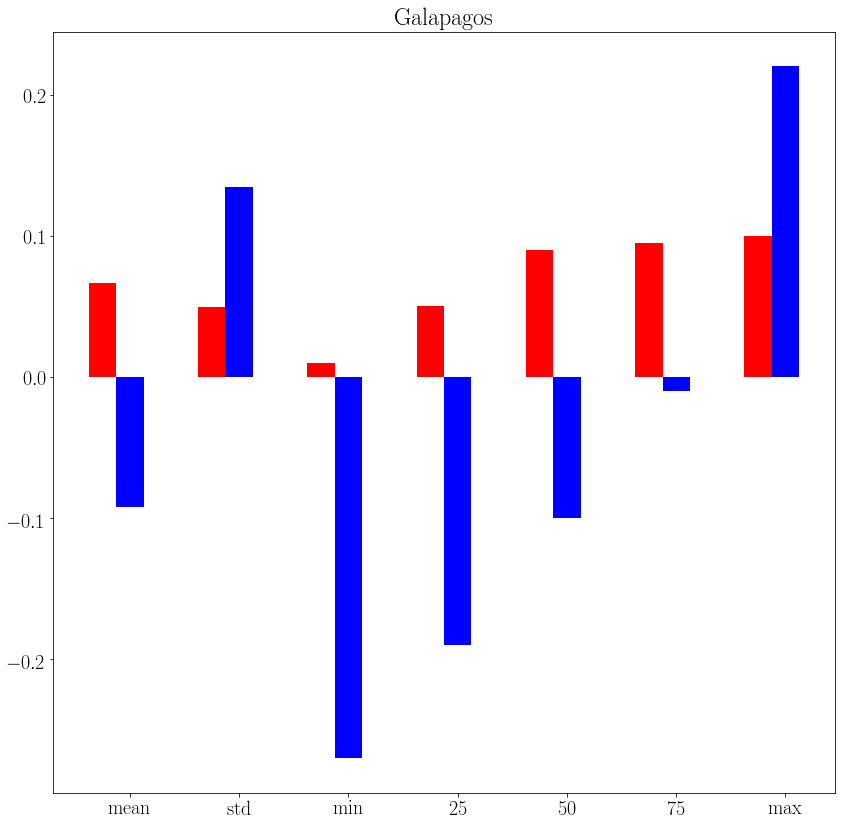

In [19]:
# Visualise the summary statistics

fig = plt.figure(figsize=(14, 14))
gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])

ax1.bar(np.arange(0,len(df_GA_Hol),1)-0.125,df_GA_Hol.d13C,tick_label=df_GA_Hol.index,color='r',width=0.25)
ax1.bar(np.arange(0,len(df_GA_LIG),1)+0.125,df_GA_LIG.d13C,tick_label=df_GA_LIG.index,color='b',width=0.25)

# Format the graph
    
ax1.set_title('Galapagos')

print('')

In [20]:
# Setup the bounds of the moving slice
Hol_time_min = 3
Hol_time_max = 10
Hol_time_step = 1
Hol_time_slice_width = 5

LIG_time_min = 116
LIG_time_max = 129
LIG_time_step = 1
LIG_time_slice_width = 5

# List of slices
Hol_time_list = [(x,y) for x,y in zip(np.arange(Hol_time_min, Hol_time_max, Hol_time_step), np.arange(Hol_time_min, Hol_time_max, Hol_time_step)+Hol_time_slice_width)]
LIG_time_list = [(x,y) for x,y in zip(np.arange(LIG_time_min, LIG_time_max, LIG_time_step), np.arange(LIG_time_min, LIG_time_max, LIG_time_step)+LIG_time_slice_width)]


def heatmap(Hol_cores,LIG_cores):
    # Evaluate the p-value over every combination of the slices
    pvalue_results = {}

    for Hol_time in Hol_time_list:
        for LIG_time in LIG_time_list:
            Hol_temp = Hol_cores[(Hol_cores.lower > Hol_time[0]) & (Hol_cores.lower < Hol_time[1])]
            LIG_temp = LIG_cores[(LIG_cores.lower > LIG_time[0]) & (LIG_cores.lower < LIG_time[1])]

            pvalue_results.update({
                str((Hol_time,LIG_time)) : stats.ttest_ind(Hol_temp.d13C, LIG_temp.d13C).pvalue
            })

    # Convert the dictionary of results to a dataframe
    pvalue_results = pd.DataFrame.from_dict(pvalue_results,orient='index')

    # # Format the indecies, and separate into different columns
    pvalue_results[['Holocene','LIG']] = pd.DataFrame([[re.sub('[^0-9,]','', y) for y in x.split('), (')] for x in pvalue_results.index],index=pvalue_results.index)
    pvalue_results = pvalue_results.rename(columns={0:'pvalue'})

    # Pivot the dataframe, so that it can be plotted as a heatmap
    pvalue_results_pivot = pd.DataFrame.pivot(pvalue_results, index='Holocene', columns='LIG', values='pvalue')
    pvalue_results = pd.DataFrame.as_matrix(pvalue_results_pivot)
    my_index = pvalue_results_pivot.index
    my_columns = pvalue_results_pivot.columns
    
    return(pvalue_results,my_index,my_columns)

GA_pvalue_results,GA_index,GA_columns = heatmap(GA_Hol_cores,GA_LIG_cores)


/home/z5145948/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


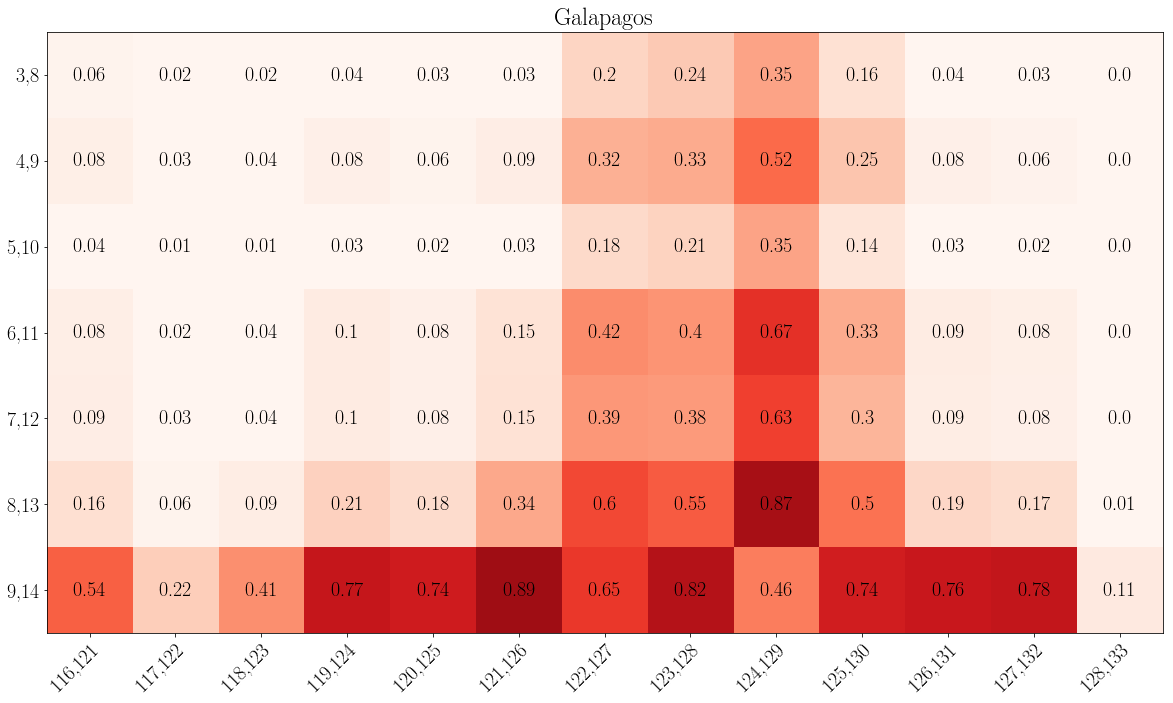

In [21]:
# Visualise the summary statistics

fig = plt.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=0.5)

gs = gridspec.GridSpec(1, 1) 
ax1 = plt.subplot(gs[0])

# get the largest pvalue so that all subplot have the same vmin,vmax
largest_pvalue = np.max([GA_pvalue_results])

for pvalue_results,my_index,my_columns,ax in zip([GA_pvalue_results],
                                                 [GA_index],
                                                 [GA_columns],
                                                 [ax1]):

    im = ax.imshow(pvalue_results,
                   cmap='Reds',
                   vmin = 0.05,
                   vmax = 1.00)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(my_columns)))
    ax.set_yticks(np.arange(len(my_index)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(my_columns)
    ax.set_yticklabels(my_index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(my_index)):
        for j in range(len(my_columns)):
            text = ax.text(j, i, int(pvalue_results[i, j]*100.0)/100.0,
                           ha="center", va="center", color="k")

ax1.set_title("Galapagos")

# plt.legend(ax1)

plt.show()